In [116]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import tqdm

K_MIN = 4
K_MAX = 7
D_MAX = 9

CASCADE_MAX_DEPTH = 10
REGEN_MAX_ITER = 20

In [117]:
jax.config.update('jax_platform_name', 'cpu')  # Force CPU-only mode

In [118]:
from flax import struct
import chex
from typing import Tuple, Union


@struct.dataclass
class MatchResults:
    """
    Match Result is a 3D matrix where:

    - Dimension 0: Depth (number of match cascades)
    - Dimension 1: Type of matches at that depth (matching 3 in a row, 4, cross etc)
    - Dimension 2: Symbol type (e.g., which game pieces matched)

    The data type is `int`, compatible with JAX.
    """

    matches: chex.Array  # Shape: (depth, num_matches_per_depth, symbol_type)

    def initialize(grid_shape: Tuple, num_symbols: int) -> "MatchResults":
        # TODO: calculate max max_possible_matches properly
        max_possible_matches = jnp.prod(grid_shape)
        return MatchResults(
            matches=jnp.zeros(
                shape=(CASCADE_MAX_DEPTH, max_possible_matches, num_symbols),
                dtype=jnp.int32,
            )
        )

In [185]:
@jax.jit
def encode_grid(grid):
    """One-hot encode the grid"""
    vals = jnp.arange(0, K_MAX + 1)
    vals = vals.at[0].set(-1)
    vals = vals[:, jnp.newaxis, jnp.newaxis]
    return jnp.astype(grid == vals, int)


@jax.jit
def decode_grid(grid):
    """Decode one-hot encoded grid."""
    vals = jnp.arange(0, K_MAX + 1)
    vals = vals.at[0].set(-1)
    vals = vals[:, jnp.newaxis, jnp.newaxis]
    return jnp.sum(vals * grid, axis=0)


def plot_grid(grid, ax, matches=None, vmin=None, vmax=None):
    ax.grid(color="white", linewidth=2)
    ax.set_xticks(jnp.arange(-0.5, 9.5, 1), [])
    ax.set_yticks(jnp.arange(-0.5, 9.5, 1), [])

    # TODO: this should be tested
    if matches is not None:
        # Highlight matched cells with red borders
        for i in range(len(matches)):
            for j in range(len(matches[0])):
                if matches[i, j]:
                    # Draw a red rectangle around the matched cell
                    ax.add_patch(
                        plt.Rectangle(
                            (j, i),
                            1,
                            1,
                            fill=False,
                            edgecolor="red",
                            lw=3,  # Border thickness
                        )
                    )

    ax.imshow(grid, vmin=vmin, vmax=vmax)

[4 4 2 3 1 1 4 1 3]


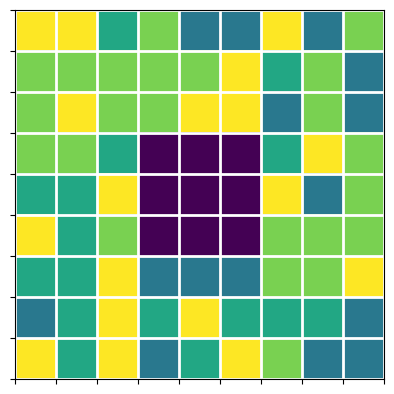

In [221]:
from functools import partial


def generate_random_grid(key, k, mask):
    grid = jax.random.randint(key, (D_MAX, D_MAX), 1, k + 1)
    grid = jnp.where(mask == 0, grid, -1)
    return grid


key = jax.random.key(seed=3)

k = 4
# mask = jnp.array([
#     [1, 1, 0, 0, 0, 0, 0, 1, 1],
#     [1, 1, 0, 0, 0, 0, 0, 1, 1],
#     [0, 0, 0, 0, 0, 0, 0, 0, 0],
#     [0, 0, 0, 0, 0, 0, 0, 0, 0],
#     [0, 0, 0, 0, 0, 0, 0, 0, 0],
#     [0, 0, 0, 0, 0, 0, 0, 0, 0],
#     [0, 0, 0, 0, 0, 0, 0, 0, 0],
#     [1, 1, 0, 0, 0, 0, 0, 1, 1],
#     [1, 1, 0, 0, 0, 0, 0, 1, 1],
# ])
mask = jnp.array(
    [
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 1, 0, 0, 0],
        [0, 0, 0, 1, 1, 1, 0, 0, 0],
        [0, 0, 0, 1, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
    ],
    dtype=jnp.int32,
)
grid = jax.jit(generate_random_grid)(key, k, mask)
print(grid[0])
plot_grid(grid, plt.gca(), vmin=-1, vmax=k)
plt.show()

In [222]:
ROLL_DIRECTIONS = [
    (-1, 0),  # roll up
    (1, 0),  # roll down
    (-1, 1),  # roll left
    (1, 1),  # roll right
]

def __translate_grid(grid, direction):
    def mask_vertical_fn(carry):
        grid, p = carry
        return grid.at[p, :].set(-1)

    def mask_horizontal_fn(carry):
        grid, p = carry
        return grid.at[:, p].set(-1)

    translated_grid = jnp.roll(grid, direction[0], axis=direction[1])

    p = jax.lax.cond(direction[0] == 1, lambda: 0, lambda: -1)
    grid = jax.lax.cond(
        direction[1] == 0,
        mask_vertical_fn,
        mask_horizontal_fn,
        (translated_grid, p),
    )
    return grid

def find_matches(grid):
    grid_roll_up = __translate_grid(grid, ROLL_DIRECTIONS[0])
    grid_roll_down = __translate_grid(grid, ROLL_DIRECTIONS[1])
    grid_roll_left = __translate_grid(grid, ROLL_DIRECTIONS[2])
    grid_roll_right = __translate_grid(grid, ROLL_DIRECTIONS[3])


    vertical_matches = jnp.equal(grid, grid_roll_up) & jnp.equal(grid, grid_roll_down)
    vertical_matches = jnp.logical_or(
        vertical_matches,
        jnp.logical_or(
            jnp.roll(vertical_matches, shift=-1, axis=0),
            jnp.roll(vertical_matches, shift=1, axis=0),
        ),
    )
    horizontal_matches = jnp.equal(grid, grid_roll_left) & jnp.equal(
        grid, grid_roll_right
    )
    horizontal_matches = jnp.logical_or(
        horizontal_matches,
        jnp.logical_or(
            jnp.roll(horizontal_matches, shift=-1, axis=1),
            jnp.roll(horizontal_matches, shift=1, axis=1),
        ),
    )
    # print(vertical_matches)

    all_matches = jnp.logical_or(vertical_matches, horizontal_matches)
    all_matches = jnp.where(grid == -1, False, all_matches)

    return all_matches

In [223]:
def generate_grid(key, num_symbols, mask=None):
    max_iter = 25
    if mask is None:
        mask = jnp.zeros((D_MAX, D_MAX))

    def cond_fn(carry):
        _, _, matches, i = carry
        return jnp.logical_and(jnp.sum(matches) > 0, i < max_iter)

    def body_fn(carry):
        key, grid, matches, i = carry
        key, subkey = jax.random.split(key)
        random_grid = generate_random_grid(subkey, num_symbols, mask)
        grid = jnp.where(matches, random_grid, grid)
        new_matches = find_matches(grid)
        return (key, grid, new_matches, i + 1)

    
    initial_grid = generate_random_grid(key, num_symbols, mask)
    initial_matches = find_matches(initial_grid)
    key, grid, matches, i = jax.lax.while_loop(cond_fn, body_fn, (key, initial_grid, initial_matches, 0))
    return key, initial_grid, grid, matches, i

In [224]:
key = jax.random.key(seed=42)
key, initial_grid, grid, _, _ = jax.jit(generate_grid)(key, 4, mask)
print("GENERATED!")
grid_match = jnp.astype(find_matches(grid), int)
grid_match


GENERATED!


Array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

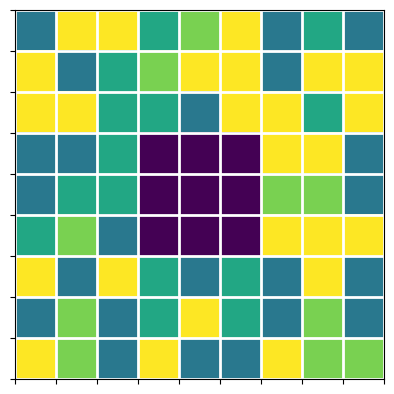

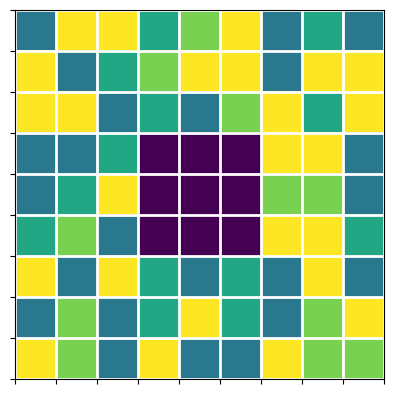

min_symbol -1
max_symbol 4


In [225]:
key, initial_grid, grid_no_matches, _, _ = jax.jit(generate_grid)(key, 4, mask)
plot_grid(initial_grid, plt.gca())
plt.show()
plot_grid(grid_no_matches, plt.gca())
plt.show()
# plot_grid(grid_match, plt.gca())

print("min_symbol", jnp.min(initial_grid))
print("max_symbol", jnp.max(initial_grid))


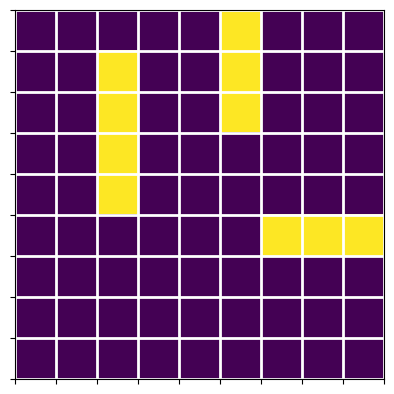

In [226]:
grid_match = jnp.astype(jax.jit(find_matches)(initial_grid), int)
plot_grid(grid_match, plt.gca())

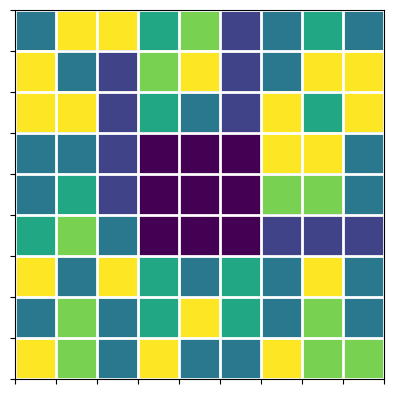

In [227]:
def remove_matches(grid):
    matches = find_matches(grid)
    grid = jnp.where(matches, 0, grid)
    return grid

# grid = generate_random_grid(jax.random.PRNGKey(1), (9,9), 4, mask)
grid = jax.jit(remove_matches)(initial_grid)
plot_grid(grid, plt.gca())


In [228]:
@jax.jit
def collapse_grid(grid):
    def process_column(col_v):
        col_i = jnp.arange(0, 9)
        col_w = jnp.astype(col_v == -1, jnp.int4) - jnp.astype(col_v == 0, jnp.int4)

        order = jnp.argsort(col_w, stable=True)
        col_i = col_i[order]
        col_v = col_v[order]

        l_mask = col_v != -1
        r_mask = col_v == -1

        col_i = (
            jnp.sort(col_i * l_mask + D_MAX * r_mask) * l_mask
            + col_i * r_mask
        )

        order = jnp.argsort(col_i, stable=True)
        return col_v[order]
    
    # Vectorize over columns
    processed_cols = jax.vmap(process_column)(grid.T)
    return processed_cols.T

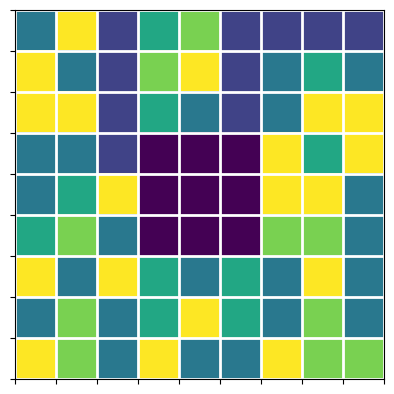

In [229]:
grid = jax.jit(collapse_grid)(grid)
plot_grid(grid, plt.gca())

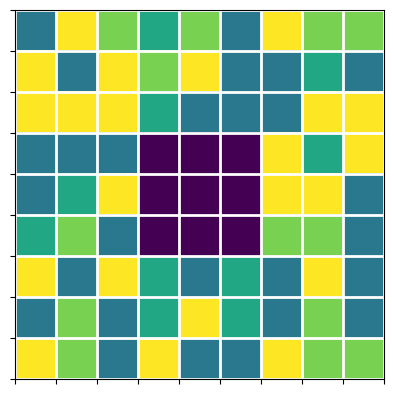

In [231]:
def refill_grid(key, grid, k, mask):
    key, subkey = jax.random.split(key)
    random_grid = generate_random_grid(subkey, k, mask)
    return jnp.where(grid == 0, random_grid, grid)

grid_new = jax.jit(refill_grid)(key, grid, 4, mask)
plot_grid(grid_new, plt.gca())

In [238]:
def __translate_row(grid, row_idx, direction):
    row_v = grid.at[row_idx, :].get()
    row_v = jnp.roll(row_v, direction)
    row_v = jax.lax.cond(direction > 0, lambda: row_v.at[0].set(-1), lambda: row_v.at[-1].set(-1))
    return grid.at[row_idx, :].set(row_v)

def __translate_column(grid, col_idx, direction: int):
    col_v = grid.at[:, col_idx].get()
    col_v = jnp.roll(col_v, direction)
    col_v = jax.lax.cond(direction > 0, lambda: col_v.at[0].set(-1), lambda: col_v.at[-1].set(-1))
    return grid.at[:, col_idx].set(col_v)

def __reapply_mask(grid, mask):
    return grid * jnp.logical_xor(grid, mask) - mask

def __get_translated_grids_tuple(grid, mask):
    grid_new_down = jax.vmap(__translate_column, in_axes=(None, 0, None))(grid, jnp.arange(D_MAX), -1)
    grid_new_up = jax.vmap(__translate_column, in_axes=(None, 0, None))(grid, jnp.arange(D_MAX), 1)
    grid_new_right = jax.vmap(__translate_row, in_axes=(None, 0, None))(grid, jnp.arange(D_MAX), -1)
    grid_new_left = jax.vmap(__translate_row, in_axes=(None, 0, None))(grid, jnp.arange(D_MAX), 1)
    
    # grid_new_down = __reapply_mask(grid_new_down, mask)
    # grid_new_up = __reapply_mask(grid_new_up, mask)
    # grid_new_right = __reapply_mask(grid_new_right, mask)
    # grid_new_left = __reapply_mask(grid_new_left, mask)
    
    return grid_new_down, grid_new_up, grid_new_right, grid_new_left

9it [00:00, 38.46it/s]


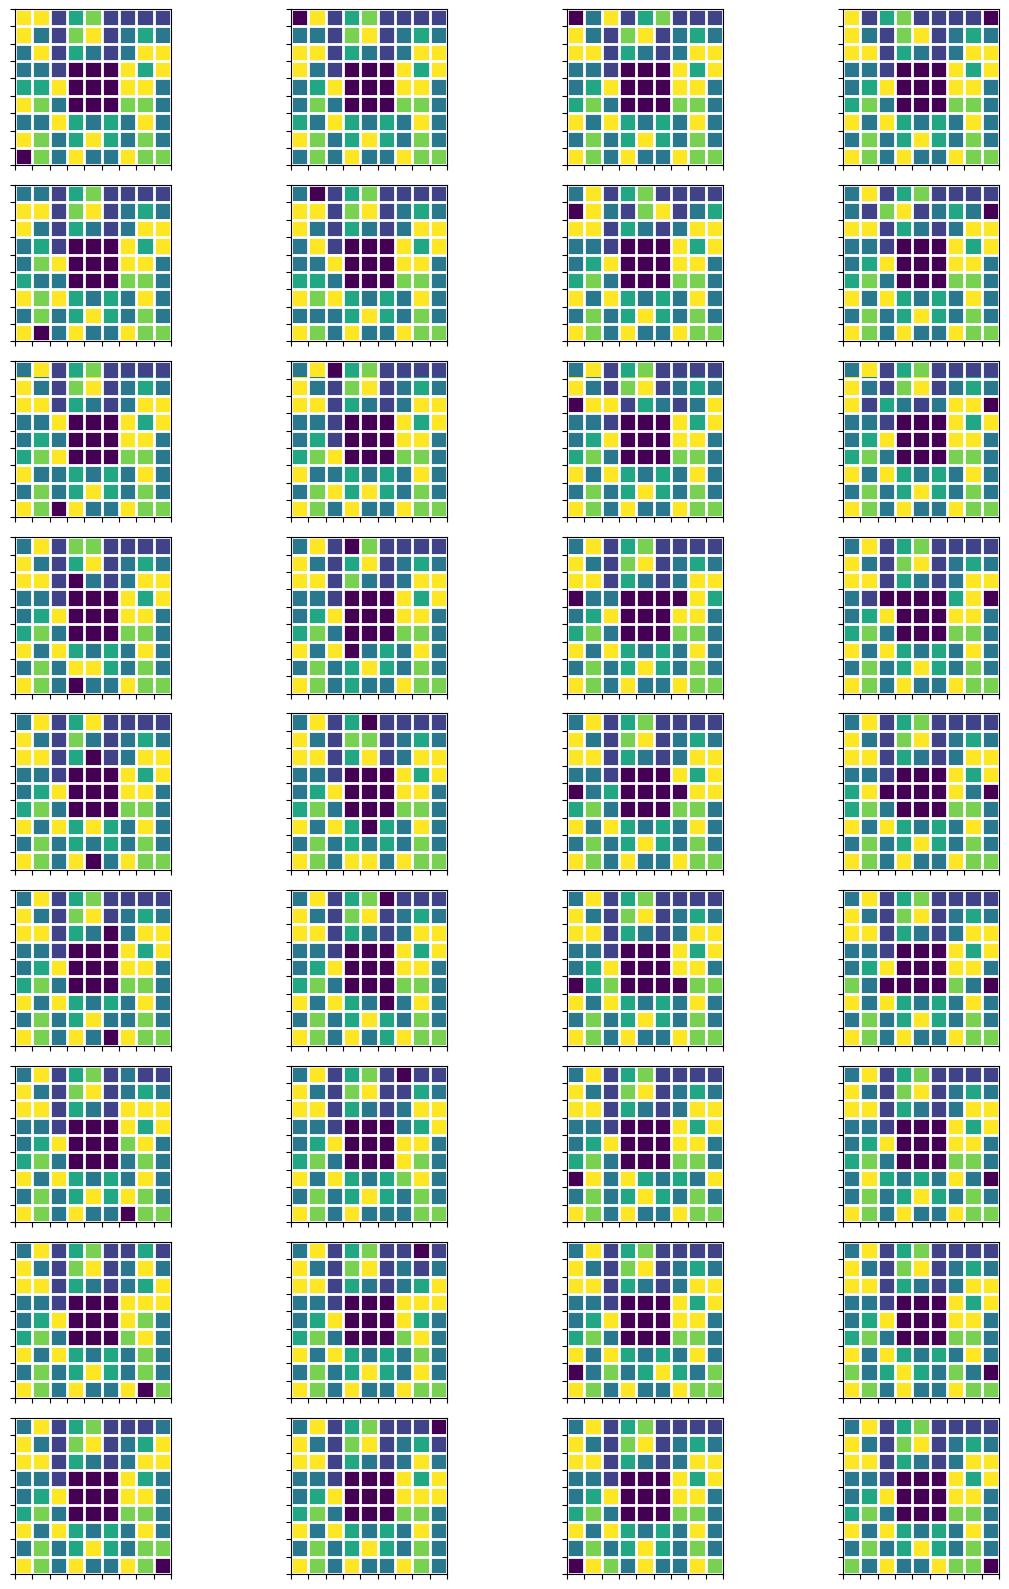

In [239]:
grid_new_down, grid_new_up, grid_new_right, grid_new_left = jax.jit(__get_translated_grids_tuple)(grid, mask)

grids = jnp.concatenate((grid_new_down, grid_new_up, grid_new_left, grid_new_right), axis=0)
grids = jax.vmap(__reapply_mask, in_axes=(0, None))(grids, mask)

fig, axs = plt.subplots(D_MAX, 4, figsize=(12, 16))
for i, (ax0, ax1, ax2, ax3) in tqdm(enumerate(axs)):
    plot_grid(grids[0+i], ax0, vmin=-1, vmax=4)
    plot_grid(grids[9*1+i], ax1, vmin=-1, vmax=4)
    plot_grid(grids[9*2+i], ax2, vmin=-1, vmax=4)
    plot_grid(grids[9*3+i], ax3, vmin=-1, vmax=4)

plt.tight_layout()
plt.show()

In [234]:
def check_no_matches(grid, mask):
    grids = jnp.concatenate(__get_translated_grids_tuple(grid, mask), axis=0)
    matches = jax.vmap(find_matches)(grids)
    return jnp.all(jnp.sum(matches, axis=(1, 2)) == 0)

In [236]:
jax.jit(check_no_matches)(grid_no_matches, mask)

Array(False, dtype=bool)

In [134]:
def generate_new_grid_if_no_matches(key, grid, k, mask):
    return jax.lax.cond(
        check_no_matches(grid, mask),
        lambda: generate_grid(key, grid.shape, k, mask),
        lambda: grid,
    )

---

In [89]:
# Masks for all possible matches.
filter_masks = jnp.array([
    [
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
    ],
    [
        [1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
    ],
    [
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
    ],
    [
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
    ],
    [
        [1, 1, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
    ],
    [
        [1, 1, 1, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
    ],
    [
        [1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
    ],
    [
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
    ],
    [
        [0, 0, 1, 0, 0],
        [1, 1, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
    ],
    [
        [1, 1, 1, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
    ],
    [
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
    ],
    [
        [1, 1, 1, 1, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
    ],
    [
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
    ],
    [
        [1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
    ]
])

# Number of matched elements for each mask.
filter_vals = jnp.array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 3, 3])

# Type of match for each mask.
filter_types = jnp.array([4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 1, 1, 0, 0])


@jax.jit
def remove_matches(grid: jnp.ndarray) -> tuple[jnp.ndarray, jnp.ndarray]:
    """Remove matches from the game grid.

    Args:
        grid: One-hot encoded game grid. The first dimension represents the
            color, second and third - the element presence.

    Returns:
        A tuple where the first element is the updated grid and the second array
        is the number of matches of each type.
    """
    grid_padded = jnp.pad(grid, 4)
    matches = jnp.zeros(5)

    # Iterate over each filter.
    for filter_mask, filter_val, filter_type in zip(filter_masks, filter_vals, filter_types):

        # Iterate over each grid cell skipping padding.
        for i in range(4, 13):
            for j in range(4, 13):

                # Grid under the filter.
                # grid_slice.shape = (11, 13, 13).
                grid_slice = grid_padded.at[5:, i:i + 5, j:j + 5].get()

                # Remove match from the slice if the filter is active.
                # is_filter_active.shape = (11, 1, 1).
                is_filter_active = jnp.sum(grid_slice * filter_mask, axis=[1, 2]) == filter_val
                is_filter_active = is_filter_active[:, jnp.newaxis, jnp.newaxis]

                # grid_slice.shape = (11, 13, 13).
                grid_slice = jnp.logical_xor(grid_slice, is_filter_active * filter_mask)

                # Increment match for each filter activation.
                matches = matches.at[filter_type].add(is_filter_active.sum())

                # Store grid with updated slice.
                grid_padded = grid_padded.at[5:, i:i + 5, j:j + 5].set(grid_slice)

    return grid_padded.at[4:-4, 4:13, 4:13].get(), matches

In [ ]:
@jax.jit
def collapse_grid(grid):
    for i in range(D_MAX):
        col_v = grid.at[:, i].get()

        col_i = jnp.arange(0, 9)
        col_w = jnp.astype(col_v == -1, jnp.int4) - jnp.astype(col_v == 0, jnp.int4)

        order = jnp.argsort(col_w, stable=True)
        col_i = col_i[order]
        col_v = col_v[order]

        l_mask = col_v != -1
        r_mask = col_v == -1

        col_i = (
            jnp.sort(col_i * l_mask + D_MAX * r_mask) * l_mask
            + col_i * r_mask
        )

        order = jnp.argsort(col_i, stable=True)
        col_v = col_v[order]
        grid = grid.at[:, i].set(col_v)
    
    return grid

In [213]:
@jax.jit
def refill_grid(key, grid, k):
    key, subkey = jax.random.split(key)
    random_grid = jax.random.randint(subkey, (D_MAX, D_MAX), 1, k + 1)
    return grid + random_grid * (grid == 0)

100%|██████████| 6/6 [01:04<00:00, 10.70s/it]


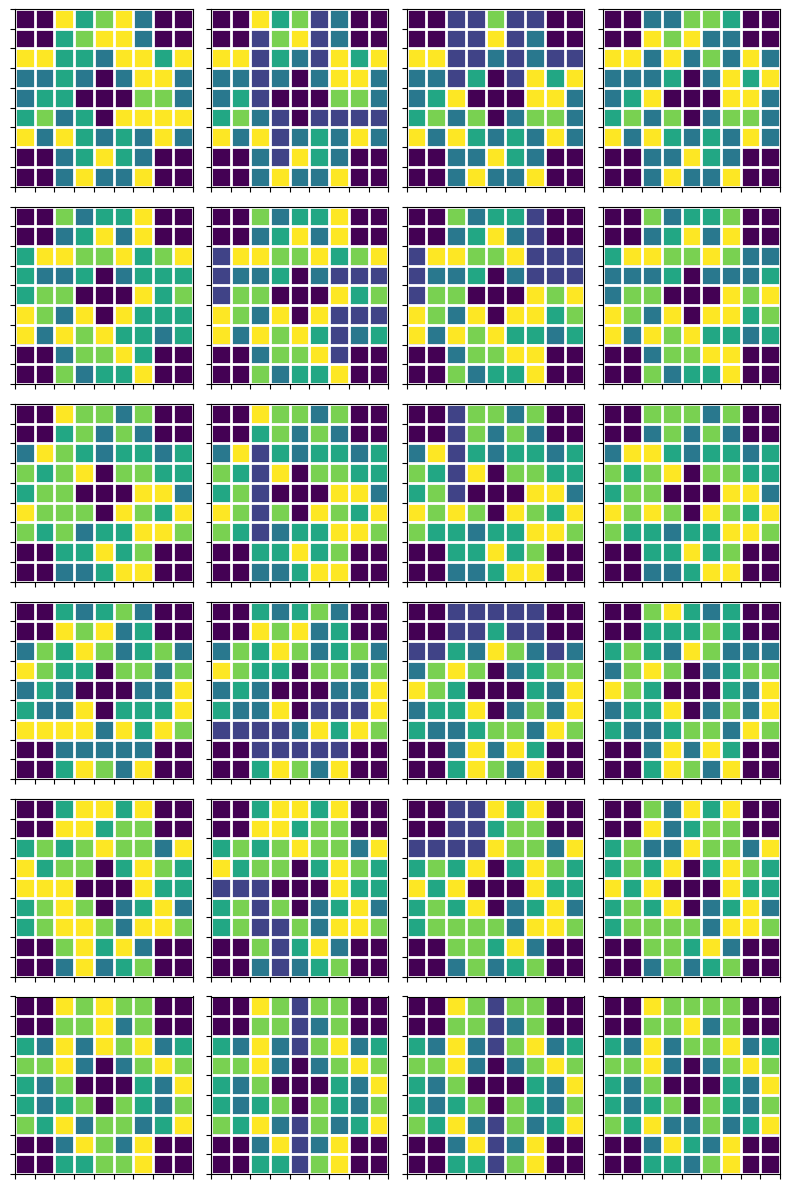

In [216]:
key = jax.random.key(seed=42)

k = 4
mask = jnp.array([
    [1, 1, 0, 0, 0, 0, 0, 1, 1],
    [1, 1, 0, 0, 0, 0, 0, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 1, 1],
    [1, 1, 0, 0, 0, 0, 0, 1, 1],
])

fig, axs = plt.subplots(6, 4, figsize=(8, 12))
for ax0, ax1, ax3, ax4 in tqdm(axs):
    key, subkey = jax.random.split(key)
    grid = generate_random_grid(key, k, mask)
    plot_grid(grid, ax0, vmin=-1, vmax=4)

    grid, matches = remove_matches(encode_grid(grid))
    grid = decode_grid(grid)
    plot_grid(grid, ax1, vmin=-1, vmax=4)

    grid = collapse_grid(grid)
    plot_grid(grid, ax3, vmin=-1, vmax=4)

    key, subkey = jax.random.split(key)
    grid = refill_grid(key, grid, 4)
    plot_grid(grid, ax4, vmin=-1, vmax=4)

plt.tight_layout()
plt.show()